# Data mapping

In this session, we will build on all we have learnt so far about loading and manipulating (spatial) data and apply it to one of the most commonly used forms of spatial analysis: choropleths. Remember these are maps that display the spatial distribution of a variable encoded in a color scheme, also called *palette*. Although there are many ways in which you can convert the values of a variable into a specific color, we will focus in this context only on a handful of them, in particular:

* Unique values.
* Equal interval.
* Quantiles.
* Fisher-Jenks.

In addition, we will cover how to add base maps that provide context from rasters and, in two optional extensions, will review two more additional ways of displaying data in maps: cartograms and conditional maps.

Before all this mapping fun, let us get the importing of libraries and data loading out of the way:

In [12]:
%matplotlib inline

# import seaborn as sns
import pandas as pd
import seaborn as sns
import pysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

## Data

For this tutorial, we will use the recently released 2015 Index of Multiple Deprivation (IMD) for England and Wales. This dataset can be most easily downloaded from the CDRC data store ([link](https://data.cdrc.ac.uk/dataset/cdrc-english-indices-of-deprivation-2015-geodata-pack-liverpool-e08000012)) and, since it already comes both in tabular as well as spatial data format (shapefile), it does not need merging or joining to additional geometries.

Although all the elements of the IMD, including the ranks and the scores themselves, are in the IMD dataset, we will also be combining them with additional data from the Census, to explore how deprivation is related to other socio-demographic characteristics of the area. For that we will revisit the Census Data Pack ([link](https://data.cdrc.ac.uk/dataset/cdrc-2011-census-data-packs-for-local-authority-district-liverpool-e08000012)) we used previously.

In order to create maps with a base layer that provides context, we will be using a raster file derived from [OS VectorMap District (Backdrop Raster)](https://www.ordnancesurvey.co.uk/business-and-government/products/vectormap-district.html) and available for download on [this link](http://darribas.org/gds15/content/labs/figs/lab04_liverpool.tif).

As usual, let us set the paths to the folders containing the files before anything so we can then focus on data analysis exclusively (keep in mind the specific paths will probably be different for your computer):

In [3]:
# This will be different on your computer and will depend on where
# you have downloaded the files
imd_shp = './data/shapefiles/E08000012.shp'
liv_path = './data/lab04_liverpool.tif'
data_path = './data/'

* **IMD data**

Now we can load up the IMD data exactly as we did earlier for a shapefile:

In [4]:
# Read the file in
imd = gpd.read_file(imd_shp)
# Index it on the LSOA ID
imd = imd.set_index('LSOA11CD')
# Display summary
imd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 298 entries, E01006512 to E01033768
Data columns (total 12 columns):
imd_rank      298 non-null int64
imd_score     298 non-null float64
income        298 non-null float64
employment    298 non-null float64
education     298 non-null float64
health        298 non-null float64
crime         298 non-null float64
housing       298 non-null float64
living_env    298 non-null float64
idaci         298 non-null float64
idaopi        298 non-null float64
geometry      298 non-null object
dtypes: float64(10), int64(1), object(1)
memory usage: 30.3+ KB


Note how on line 4 we *index* the resulting table `imd` with the column `LSOA11CD`. Effectively, this means we are "naming" the rows, the same way we the columns are named, using the column `LSOA11CD`, which contains the unique ID's of each area. This affords us some nice slicing and querying capabilities as well as permitting to merge the table with other ones more easily. 

Pay attention also to how exactly we index the table: we create a new object that is named in the same way, `imd`, but that contains the result of applying the function `set_index` to the original object `imd`. As usual, there are many ways to index a table in Python, but this is one of the most direct and expressive ones.

* **Census data**

In order to explore additional dimensions of deprivation, and to have categorical data to display with "unique values" choropleths, we will use some of the Census data pack. Although most of the Census variables are continuous, we will transform them to create *categorical* characteristics. Remember a categorical variable is one that comprises only a limited number of potential values, and these are not comparable with each other across a numerical scale. For example, religion or country of origin are categorical variables. It is not possible to compare their different values in a quantitative way (religion A is not double or half of religion B) but instead they represent qualitative differences.

In particular, we are going to use tables `QS104EW` (Gender) and `KS103EW` (marital status). The way these are presented in its raw form is as tabulated counts of each of the possible categories. Our strategy to turn these into a single categorical variable for each case is to compare the counts for each area and assign that of the largest case. For example, in the first case, an area will be labelled as "male" if there are more males than females living in that particular LSOA. In the case of marital status, although there are more cases, we will simplify and use only "married" and "single" and assign one or the other on the bases of which ones are more common in each particular area.

**NOTE**: the following code snippet involves some data transformations that are a bit more advanced that what is covered in this course. Simply run them to load the data, but you are not expected to know some of the coding tricks required in this cell.

In [5]:
                # Gender breakup
# Read table (csv file)
gender = pd.read_csv(data_path+'tables/QS104EW_lsoa11.csv', index_col='GeographyCode')
# Rename columns from code to human-readable name
gender = gender.rename(columns={'QS104EW0002': 'Male', \
                                'QS104EW0003': 'Female'})[['Male', 'Female']]
# Create male-female switcher
maj_male = gender['Male'] > gender['Female']
# Add "Gender_Majority" variable to table and assign the switcher
gender['Gender_Majority'] = maj_male
# Replace `True` values with "Male" and `False` with "Female"
gender.loc[gender['Gender_Majority']==True, 'Gender_Majority'] = 'Male'
gender.loc[gender['Gender_Majority']==False, 'Gender_Majority'] = 'Female'

                # Status breakup
# Read table (csv file)
sinmar = pd.read_csv(data_path+'tables/KS103EW_lsoa11.csv', index_col='GeographyCode')
# Rename columns from code to human-readable name
sinmar = sinmar.rename(columns={'KS103EW0002': 'Single', \
                                'KS103EW0003': 'Married'})[['Single', 'Married']]
# Create sigle-married switcher
maj_sin = sinmar['Single'] > sinmar['Married']
# Add "Status_Majority" variable to table and assign the switcher
sinmar['Status_Majority'] = maj_sin
# Replace `True` values with "Single" and `False` with "Married"
sinmar.loc[sinmar['Status_Majority']==True, 'Status_Majority'] = 'Single'
sinmar.loc[sinmar['Status_Majority']==False, 'Status_Majority'] = 'Married'

# Join
both = imd.join(sinmar).join(gender)
# Reset the CRS after join
both.crs = imd.crs

This creates the table we will be using for the rest of the session:

In [6]:
both.head()

,imd_rank,imd_score,income,employment,education,health,crime,housing,living_env,idaci,idaopi,geometry,Single,Married,Status_Majority,Male,Female,Gender_Majority
LSOA11CD,,,,,,,,,,,,,,,,,,
E01006512,10518,25.61,0.10,0.08,10.06,1.19,-0.20,24.49,68.91,0.16,0.31,"POLYGON ((336103.358 389628.58, 336103.416 389...",1288,287,Single,1070,810,Male
E01006513,10339,25.91,0.04,0.03,20.13,0.58,1.50,25.15,85.48,0.21,0.20,"POLYGON ((335173.781 389691.538, 335169.798 38...",2613,170,Single,1461,1480,Female
E01006514,5247,37.64,0.19,0.15,15.50,1.86,0.74,21.85,58.90,0.23,0.48,"POLYGON ((335495.676 389697.267, 335495.444 38...",1583,204,Single,1177,931,Male
E01006515,1019,58.99,0.43,0.30,33.51,1.90,1.16,17.40,29.78,0.46,0.76,"POLYGON ((334953.001 389029, 334951 389035, 33...",587,218,Single,595,613,Female
E01006518,662,63.37,0.43,0.34,49.90,2.24,0.67,15.52,31.03,0.50,0.52,"POLYGON ((335354.015 388601.947, 335354 388602...",716,363,Single,843,853,Female


A look at the variables reveals that, in effect, we have successfuly merged the IMD data with the categorical variables derived from Census tables:

In [7]:
both.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 298 entries, E01006512 to E01033768
Data columns (total 18 columns):
imd_rank           298 non-null int64
imd_score          298 non-null float64
income             298 non-null float64
employment         298 non-null float64
education          298 non-null float64
health             298 non-null float64
crime              298 non-null float64
housing            298 non-null float64
living_env         298 non-null float64
idaci              298 non-null float64
idaopi             298 non-null float64
geometry           298 non-null object
Single             298 non-null int64
Married            298 non-null int64
Status_Majority    298 non-null object
Male               298 non-null int64
Female             298 non-null int64
Gender_Majority    298 non-null object
dtypes: float64(10), int64(5), object(3)
memory usage: 54.2+ KB


Now we are fully ready to map!

## Choropleths

### Unique values

A choropleth for categorical variables simply assigns a different color to every potential value in the series. The main requirement in this case is then for the color scheme to reflect the fact that different values are not ordered or follow a particular scale.

In Python, thanks to `geopandas`, creating categorical choropleths is possible with one line of code. To demonstrate this, we can plot the spatial distribution of LSOAs with a more female population than male and viceversa:

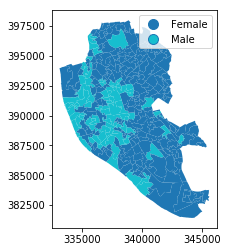

In [8]:
both.plot(column='Gender_Majority', categorical=True, legend=True)

Let us stop for a second in a few crucial aspects:

* Note how we are using the same approach as for basic maps, the command `plot`, but we now need to add the argument `column` to specify which column in particular is to be represented.
* Since the variable is categorical we need to make that explicit by setting the argument `categorical` to `True`.
* As an optional argument, we can set `legend` to `True` and the resulting figure will include a legend with the names of all the values in the map.
* Unless we specify a different colormap, the selected one respects the categorical nature of the data by not implying a gradient or scale but a qualitative structure.

---

**[Optional exercise]**

Create a categorical map of the marital status in Liverpool. Where are the areas with more married than single population?

---

### Equal interval

If, instead of categorical variables, we want to display the geographical distribution of a continuous phenomenon, we need to select a way to encode each value into a color. One potential solution is applying what is usually called "equal intervals". The intuition of this method is to split the *range* of the distribution, the difference between the minimum and maximum value, into equally large segments and to assign a different color to each of them according to a palette that reflects the fact that values are ordered.

Using the example of the position of a LSOA in the national ranking of the IMD (`imd_rank`), we can calculate these segments, also called bins or buckets, using the library `PySAL`:

In [9]:
classi = ps.Equal_Interval(imd['imd_rank'], k=7)
classi

                 Equal Interval                
 
  Lower              Upper                Count
            x[i] <=  4604.857               156
 4604.857 < x[i] <=  9185.714                48
 9185.714 < x[i] <= 13766.571                30
13766.571 < x[i] <= 18347.429                21
18347.429 < x[i] <= 22928.286                24
22928.286 < x[i] <= 27509.143                14
27509.143 < x[i] <= 32090.000                 5

The only additional argument to pass to `Equal_Interval`, other than the actual variable we would like to classify is the number of segments we want to create, `k`, which we are arbitrarily setting to seven in this case. This will be the number of colors that will be plotted on the map so, although having several can give more detail, at some point the marginal value of an additional one is fairly limited, given the ability of the brain to tell any differences.

Once we have classified the variable, we can check the actual break points where values stop being in one class and become part of the next one:

In [10]:
classi.bins

array([ 4604.85714286,  9185.71428571, 13766.57142857, 18347.42857143,
       22928.28571429, 27509.14285714, 32090.        ])

The array of breaking points above implies that any value in the variable below 4604.9 will get the first color in the gradient when mapped, values between 4604.9 and 9185.7 the next one, and so on.

The key characteristic in equal interval maps is that the bins are allocated based on the magnitude on the values, irrespective of how many obervations fall into each bin as a result of it. In highly skewed distributions, this can result in bins with a large number of observations, while others only have a handful of outliers. This can be seen in the submmary table printed out above, where 156 LSOAs are in the first group, but only five of them belong to the one with highest values. This can also be represented visually with a kernel density plot where the break points are included as well:

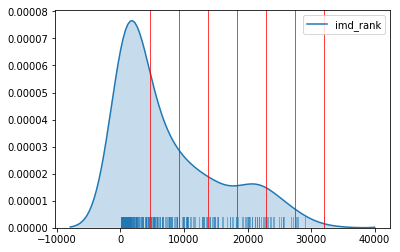

In [13]:
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(imd['imd_rank'], shade=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(imd['imd_rank'], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
# Display image
plt.show()

Technically speaking, the figure is created by overlaying a KDE plot with vertical bars for each of the break points. This makes much more explicit the issue highlighed by which the first bin contains a large amount of observations while the one with top values only encompasses a handful of them.

To create a map that displays the colors assigned by the equal interval classification algorithm, we use a similar approach as with unique values but with some key differences:

C:\Users\mtenney\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


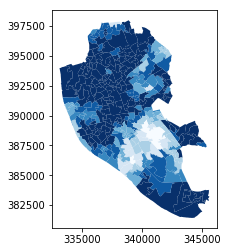

In [14]:
imd.plot(column='imd_rank', scheme='equal_interval', k=7, colormap=plt.cm.Blues_r, alpha=1)

Pay attention to the key differences:

* Instead of specifyig `categorical` as `True`, we replace it by the argument `scheme`, which we will use for all choropleths that require a continuous classification scheme. In this case, we set it to `equal_interval`.
* As above, we set the number of colors to 7. Note that we need not pass the bins we calculated above, the plotting method does it itself under the hood for us.
* As optional arguments, we can change the colormap to a blue gradient, which is one of the recommended ones by [ColorBrewer](http://colorbrewer2.org/) for a sequential palette.
* Equally optional, some of the arguments we learned with basic maps, such as the degree of transparency, also apply in this context.

Substantively, the map also makes very explicit the fact that many areas are put into the same bin as the amount of white polygons is very large.

---

**[Optional exercise]**

Create an equal interval kde plot and map of the actual score of the IMD (`imd_score`). 

As a bonus, try including a legend in the map, following a similar approach as in unique values maps.

---

### Quantiles

One solution to obtain a more balanced classification scheme is using quantiles. This, by definition, assigns the same amount of values to each bin: the entire series is laid out in order and break points are assigned in a way that leaves exactly the same amount of observations between each of them. This "observation-based" approach contrasts with the "value-based" method of equal intervals and, although it can obscure the magnitude of extreme values, it can be more informative in cases with skewed distributions.

Calculating a quantiles classification with `PySAL` can be done with the following line of code:

In [15]:
classi = ps.Quantiles(imd['imd_rank'], k=7)
classi

                  Quantiles                   
 
  Lower              Upper               Count
            x[i] <=   633.714               43
  633.714 < x[i] <=  1335.714               42
 1335.714 < x[i] <=  2641.000               43
 2641.000 < x[i] <=  5540.143               42
 5540.143 < x[i] <= 10355.857               43
10355.857 < x[i] <= 18401.143               42
18401.143 < x[i] <= 32090.000               43

And, similarly, the bins can also be inspected:

In [16]:
classi.bins

array([  633.71428571,  1335.71428571,  2641.        ,  5540.14285714,
       10355.85714286, 18401.14285714, 32090.        ])

The visualization of the distribution can be generated in a similar way as well:

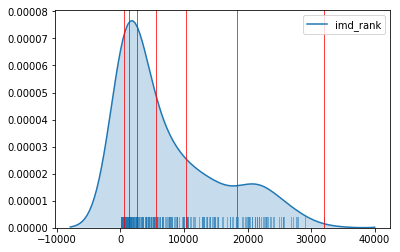

In [17]:
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(imd['imd_rank'], shade=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(imd['imd_rank'], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
# Display image
plt.show()

And the choropleth also follows a similar pattern, with the difference that we are now using the scheme "quantiles", instead of "equal interval":

C:\Users\mtenney\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


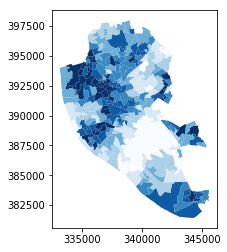

In [19]:
imd.plot(column='imd_rank', scheme='QUANTILES', alpha=1, k=7, \
         colormap=plt.cm.Blues_r, legend=False)

Note how, in this case, the amount of polygons in each color is by definition much more balanced (almost equal in fact, except for rounding differences). This obscures outlier values, which get blurred by significantly smaller values in the same group, but allows to get more detail in the "most populated" part of the distribution, where instead of only white polygons, we can now discern more variability.

---

**[Optional exercise]**

Create a quantile kde plot and map of the actual score of the IMD (`imd_score`). 

As a bonus, make a map with 50% of transparency and no boundary lines.

---

### Fisher-Jenks

Equal interval and quantiles are only two examples of very many classification schemes to encode values into colors. Although not all of them are integrated into `geopandas`, `PySAL` includes several other classification schemes (for a detailed list, have a look at this [link](http://pysal.readthedocs.org/en/latest/library/esda/mapclassify.html)). As an example of a more sophisticated one, let us create a Fisher-Jenks choropleth:

In [20]:
classi = ps.Fisher_Jenks(imd['imd_rank'], k=7)
classi

                  Fisher_Jenks                 
 
  Lower              Upper                Count
            x[i] <=  2930.000               133
 2930.000 < x[i] <=  6946.000                52
 6946.000 < x[i] <= 11656.000                39
11656.000 < x[i] <= 16185.000                24
16185.000 < x[i] <= 20719.000                20
20719.000 < x[i] <= 24098.000                18
24098.000 < x[i] <= 32090.000                12

This methodology aims at minimizing the variance *within* each bin while maximizing that *between* different classes.

In [21]:
classi.bins

array([ 2930,  6946, 11656, 16185, 20719, 24098, 32090], dtype=int64)

Graphically, we can see how the break points are not equally spaced but are adapting to obtain an optimal grouping of observations:

C:\Users\mtenney\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


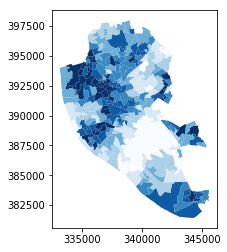

In [22]:
imd.plot(column='imd_rank', scheme='QUANTILES', alpha=1, k=7, colormap=plt.cm.Blues_r)

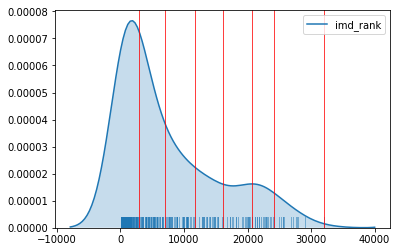

In [23]:
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(imd['imd_rank'], shade=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(imd['imd_rank'], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
# Display image
plt.show()

Technically, however, the way to create a Fisher-Jenks map is exactly the same as before:

C:\Users\mtenney\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


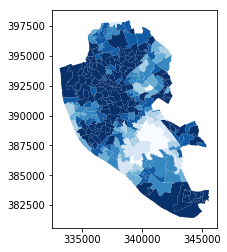

In [24]:
imd.imd_rank.plot()

## Raster basemaps

This section requires the additional library `rasterio`:

In [26]:
import rasterio

Since choropleths tend to be based on administrative boundaries which do not necessarily reflect correctly the topography of a region, it may be of interest to provide a choropleth with certain geographical context. If data are available, an easy way to deliver this is by plotting a base raster map underneath the choropleth and allowing some transparency on the upper layer.

To do this in Python, we can combine the plotting of a raster image with the generation of a choropleth as we have seen above. First, we need to read the raster in:

In [27]:
# Open the raster file
src = rasterio.open(liv_path)
# Extract the bounds
left, bottom, right, top = src.bounds

At this point we are ready to generate the figure with both layers:

C:\Users\mtenney\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
C:\Users\mtenney\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:385: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


Wall time: 1.44 s


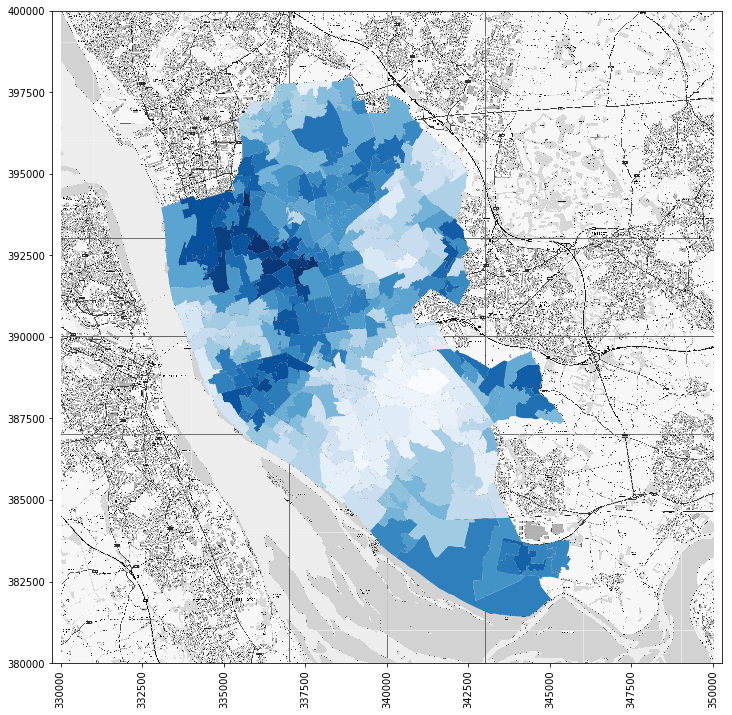

In [28]:
%%time
# Set up the figure
f, ax = plt.subplots(1, figsize=(12, 12))
# Add raster layer
ax.imshow(src.read(1), cmap='gray', extent=(left, right, bottom, top))
# Create the choropleth
imd.plot(column='imd_score', colormap='Blues', linewidth=0.1, axes=ax)
# Style the labels for the ticks
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
# Keep axes proportionate
plt.axis('equal')

Note how the way the raster is added to the axis is different that the way we attach a vector map: the raster gets plotted through `imshow` (image show), which is a function embedded in the axis object (`ax`), while the vector object is appended by passing the axis (`ax`) through the plotting method itself.

## Zooming into the map

A general map of an entire region, or urban area, can sometimes obscure particularly local patterns because they happen at a much smaller scale that cannot be perceived in the global view. One way to solve this is by providing a focus of a smaller part of the map in a separate figure. Although there are many ways to do this in Python, the most straightforward one is to reset the limits of the axes to center them in the area of interest.

As an example, let us consider the quantile map produced above:

C:\Users\mtenney\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


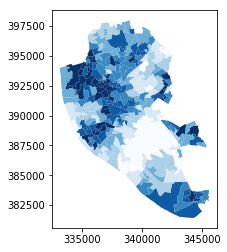

In [29]:
imd.plot(column='imd_rank', scheme='QUANTILES', alpha=1, k=7, colormap=plt.cm.Blues_r)

If we want to focus on the city centre, say the area of the map more or less between coordinates 387,000 and 391,000 on the vertical axis, and 332,000 and 337,000 on the horizontal one, creating the figure involves the following:

C:\Users\mtenney\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
C:\Users\mtenney\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:385: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


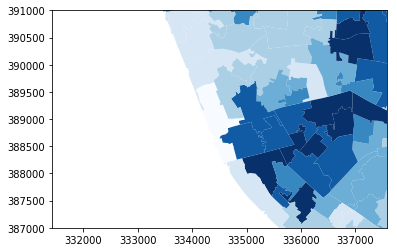

In [30]:
# Setup the figure
f, ax = plt.subplots(1)
# Draw the choropleth
imd.plot(column='imd_rank', scheme='QUANTILES', alpha=1, k=7, \
         colormap=plt.cm.Blues_r, axes=ax)
# [Optional] Keep axes proportionate
plt.axis('equal')
# Redimensionate X and Y axes to desired bounds
ax.set_ylim(387000, 391000)
ax.set_xlim(332000, 337000)
# Show image
plt.show()

Note how, if we decide to keep the axes proportionate, it needs to be done *before* resetting the limits, as otherwise the change will not have an effect.

## `[Extension 1]` Cartograms

Cartograms are maps that represent the spatial distribution of a variable not by encoding it in a color palette by rather by modifying geographical objects. There are many algorithms to distort the shapes of geographical entities according to values, some of them incredibly complicated and complex. 

As an example of how to create a relatively straight-forward cartogram, we will convert polygons into points by using their centroids, and will define the size of the dot proportionally to the value of the variable we want to display, the IMD score in this case. We will adopt a different approach to plot points than we have done so far. This involves first extracting the coordinates of the points:

In [31]:
pts = np.array([(pt.x, pt.y) for pt in imd.centroid])

**NOTE**: The line of code above contains some elements that reflect more advanced Python programming that we have covered so far, so you should feel free to simply run it to extract the points.

---

If you are interested in the logic however, it uses a technique called "list comprehension", which can compress and entire `for` loop into a single line of code, producing more elegant and, to the trained eye, more readable code. Essentially, the line above can be unpacked into the following loop:

In [32]:
pts = []
for pt in imd.centroid:
    pts.append((pt.x, pt.y))
pts = np.array(pts)

---

Once we have extracted them, we can display them through the command `plt.scatter`. This is equivalent to the straightforward `plot`, or to loop over each point, with the difference that it will allow us to modify the size of the dots according to a variable:

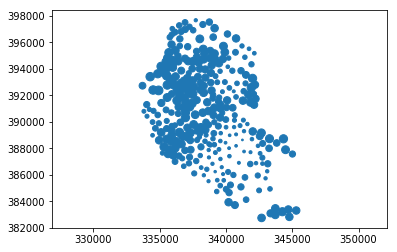

In [33]:
# Plot the dots, using `imd_score` as a variable to modify
# the size of each dot
plt.scatter(pts[:, 0], pts[:, 1], s=imd['imd_score'].values)
# Keep axes proportionate
plt.axis("equal")
# Display
plt.show()

The command `plt.scatter` can also take some of the optional arguments we have learned before, such as color. Have a look at the help of the command ([link](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter)) and try modifying some of them to explore changes in the resulting plot.

## `[Extension 2 - Advanced]` Conditional maps

Conditional maps are an attempt to explore multivariate relationships within a choropleth mapping context. In essence, they are figures composed by several choropleths in which the layout of each of them provides information about the subset of the original dataset represented. The idea is that a dataset can be subset based on one or two conditional variables, usually categorical, and only the observations that meet each characteristic are displayed in a given submap. Since they are combinations of choropleths, they build on everything we have learned about their creation. As an example, let us create a conditional map of IMD scores based on the dominating gender and marital status of each area.

From a Python perspective, creating conditional maps is a bit more intricate than simple choropleths because of the conditioning of the data and the arranging of the layout that needs to occur for the final figure to be produced. To be able to use the facetting machinery available in `seaborn`, we need to define a function that generates a choropleth with a given subset of the dataset:

In [34]:
def map_subset(vals, db, color=None, norm=True):
    '''
    Internal function to pass to `FaceGrid` to build a single map
    ...
    
    Arguments
    ---------
    vals     : Series
               Values of the subplot to be mapped
    db       : GeoDataFrame
               Table with geometries
    color    : None
    '''
    ax = plt.gca()
    for poly in db['geometry']:
        gpd.plot(ax, poly, facecolor='grey', linewidth=0.)
    vari = vals.name
    if norm:
        db.reindex(vals.index).plot(column=vari, axes=ax, colormap='Blues', linewidth=0., \
                               vmin=db[vari].min(), vmax=db[vari].max())
    else:
        db.reindex(vals.index).plot(column=vari, axes=ax, colormap='Blues', linewidth=0.)
    ax.set_axis_off()
    plt.axis('equal')

With this function in hand, we can use it to pass it on to the facetting functionality in `seaborn`, which then takes care of the actual subsetting of the data and proper alignment of the output figures:

AttributeError: module 'geopandas' has no attribute 'plot'

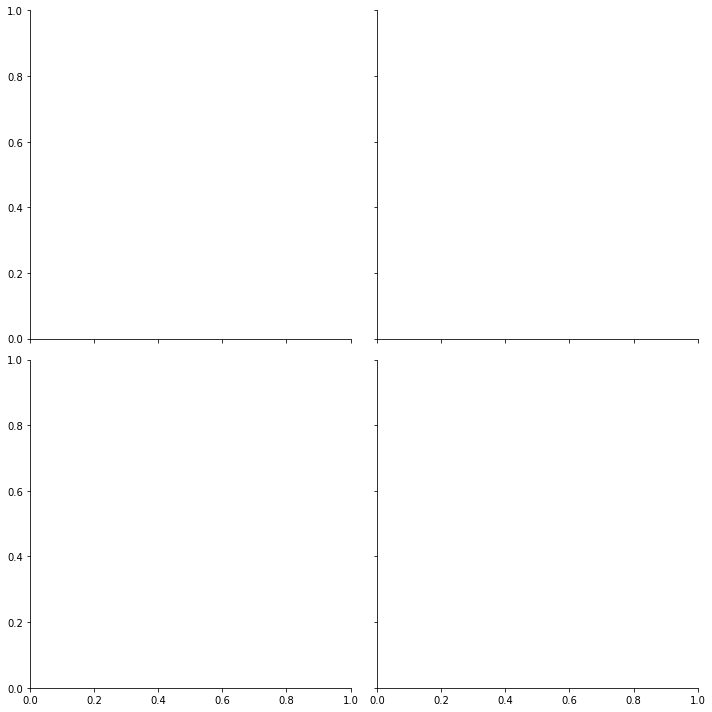

In [35]:
%%time
g = sns.FacetGrid(both, row="Gender_Majority", col="Status_Majority", \
                  margin_titles=True, size=5)
g.map(map_subset, "imd_score", db=both)
plt.tight_layout()
plt.show()

The figure contains a few interesting elements:

* The distribution of areas with different characteristics is not random over space but rather follows a specific pattern. For example, the majority of married/female areas are located in the periphery of the city, while most of the single/male LSOAs can be found in the city centre. 
* Since the color scale is common across maps, we can compare the degree of deprivation for different combinations. For example, areas with a more married population display consistently lower levels of deprivation than those where singles prevail.

Although conditional maps are a powerful tool to explore a dataset and generate hypotheses about multivariate relationships, it is important to keep in mind these can only be suggestive. A more formal analysis, such as one based on regression, would be required to establish more robust conclusions, as several confounding factors can be at play.

## `[Extension 3 - Advanced]` MAUP

Although arguably a bit more advanced, if you are curious how the maps that exemplify the [Modifiable Areal Unit Problem](https://en.wikipedia.org/wiki/Modifiable_areal_unit_problem) (MAUP) in the lecture slides, you can find a notebook illustrating it on this link:

> [https://gist.github.com/darribas/8b5a7b93d4085223f1c5#file-maup-ipynb](https://gist.github.com/darribas/8b5a7b93d4085223f1c5#file-maup-ipynb)

## `[Extension 4]` Maps from lecture slides

* Unique values

C:\Users\mtenney\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
C:\Users\mtenney\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:385: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


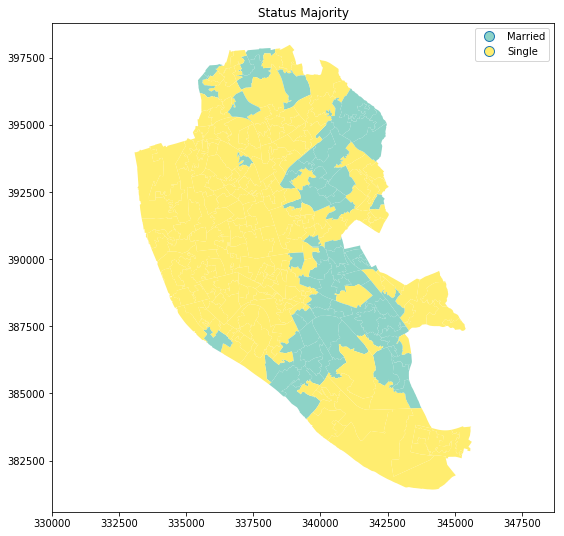

In [36]:
f, ax = plt.subplots(1, figsize=(9, 9))
both.plot(column='Status_Majority', categorical=True, legend=True, axes=ax, \
          linewidth=0.1, colormap='Set3')
ax.set_title('Status Majority')
plt.axis('equal')
#plt.savefig('../lectures/figs/l04_unique_values.png')
plt.show()

* Choropleth classifiers

In [37]:
def plot_scheme(scheme, var, db, figsize=(16, 8), saveto=None):
    '''
    Plot the distribution over value and geographical space of variable `var` using scheme `scheme
    ...
    
    Arguments
    ---------
    scheme   : str
               Name of the classification scheme to use 
    var      : str
               Variable name 
    db       : GeoDataFrame
               Table with input data
    figsize  : Tuple
               [Optional. Default = (16, 8)] Size of the figure to be created.
    saveto   : None/str
               [Optional. Default = None] Path for file to save the plot.
    '''
    from pysal.esda.mapclassify import Quantiles, Equal_Interval, Fisher_Jenks
    schemes = {'equal_interval': Equal_Interval, \
               'quantiles': Quantiles, \
               'fisher_jenks': Fisher_Jenks}
    classi = schemes[scheme](db[var], k=7)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    # KDE
    sns.kdeplot(db[var], shade=True, ax=ax1)
    sns.rugplot(db[var], alpha=0.5, ax=ax1)
    for cut in classi.bins:
        ax1.axvline(cut, color='red', linewidth=0.75)
    ax1.set_title('Value distribution')
    # Map
    p = db.plot(column=var, scheme=scheme, alpha=0.75, k=7, \
             colormap=plt.cm.Blues_r, axes=ax2, linewidth=0.1)
    ax2.axis('equal')
    ax2.set_axis_off()
    ax2.set_title('Geographical distribution')
    f.suptitle(scheme, size=25)
    if saveto:
        plt.savefig(saveto)
    plt.show()

C:\Users\mtenney\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
C:\Users\mtenney\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:385: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


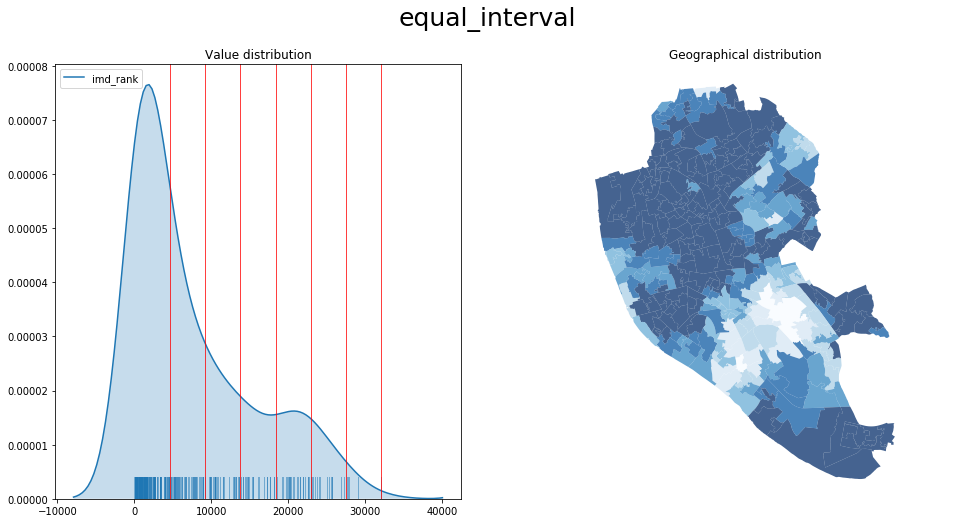

In [38]:
plot_scheme('equal_interval', 'imd_rank', imd)

* Conditional map

In [ ]:
plot_scheme('quantiles', 'imd_rank', imd)